In [1]:
import os

import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
from accelerate import Accelerator
import scanpy as sc
import pyranges as pr
import matplotlib.pyplot as plt
import polars as pl

from trackplot.plot import Plot

from torch.utils.data import DataLoader

from enformer_pytorch.data import GenomeIntervalDataset

from scooby.modeling import Scooby
from scooby.data import onTheFlyMultiomeDataset
from scooby.utils.utils import fix_rev_comp_multiome, undo_squashed_scale, get_gene_slice_and_strand, get_cell_profile_pred, region_to_bin
from scooby.utils.transcriptome import Transcriptome
from scooby.utils.plotting import add_heatmap_to_axes, plot_tracks

In [2]:
data_path = '/data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data'

In [3]:
def predict(model, seqs, seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None):
    bs = seqs.shape[0]
    # assert bs == 1
    with torch.no_grad():
        with torch.autocast("cuda"):
            outputs = model.forward_sequence_w_convs(seqs, conv_weights, conv_biases, bins_to_predict = bins_to_predict)
            if bins_to_predict is not None:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = (6143 - bins_to_predict))
            else:
                outputs_rev_comp = model.forward_sequence_w_convs(seqs_rev_comp, conv_weights, conv_biases, bins_to_predict = None)
    flipped_version = torch.flip(outputs_rev_comp,(1,-3))
    outputs_rev_comp_test = fix_rev_comp_multiome(flipped_version) 
    return (outputs + outputs_rev_comp_test)/2

In [4]:
accelerator = Accelerator(step_scheduler_with_optimizer = False)

csb = Scooby.from_pretrained(
    'johahi/neurips-scooby',
    cell_emb_dim=14,
    embedding_dim=1920,
    n_tracks=3,
    return_center_bins_only=True,
    disable_cache=False,
    use_transform_borzoi_emb=True,
)

clip_soft = 5

csb = accelerator.prepare(csb)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [5]:
gtf_file = os.path.join(data_path, "gencode.v32.annotation.sorted.gtf.gz")
fasta_file = os.path.join(data_path, "scooby_training_data", "genome_human.fa")
bed_file = os.path.join(data_path, "scooby_training_data", "sequences.bed")

In [6]:
transcriptome = Transcriptome(gtf_file)

neighbors = scipy.sparse.load_npz(os.path.join(data_path, 'scooby_training_data', 'no_neighbors.npz'))
neighbors_100 = scipy.sparse.load_npz(os.path.join(data_path, 'scooby_training_data', 'neighbors_100_no_val_genes_new.npz'))
embedding = pd.read_parquet(os.path.join(data_path, 'scooby_training_data',  'embedding_no_val_genes_new.pq'))

In [7]:
adatas = {
    'rna_plus': sc.read(
        os.path.join(data_path, 'scooby_training_data', 'snapatac_merged_plus.h5ad')
    ),
    'rna_minus': sc.read(
        os.path.join(data_path, 'scooby_training_data',  'snapatac_merged_minus.h5ad'))
    ,
    'atac': sc.read(
       os.path.join(data_path, 'scooby_training_data', 'snapatac_merged_atac.h5ad')
    ),
}

In [8]:
adata = sc.read(
    os.path.join(data_path, 'bmmc_multiome_multivi_neurips21_curated_new_palantir_fixed.h5ad'))

In [9]:
# read in ATAC peaks
atac_peaks = pr.PyRanges(pd.read_csv(os.path.join(data_path, 'scooby_training_data', 'atac_peaks.csv'), index_col=0))

## Panel B

In [10]:
size=15
params = {'legend.fontsize': 'large',
          'font.family': 'sans-serif',
          'figure.figsize': (6,6),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75}
plt.rcParams.update(params)

In [43]:
sc.settings._vector_friendly = True

In [44]:
sc.settings._vector_friendly

True

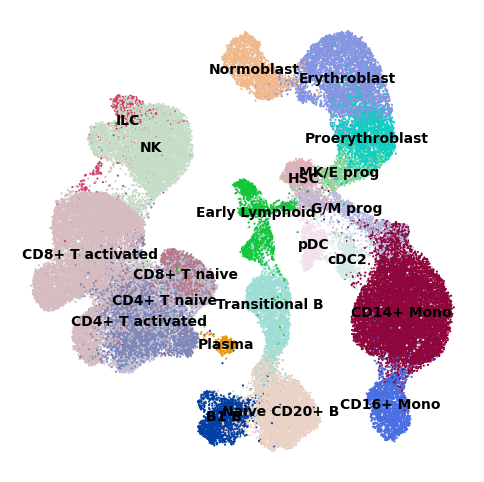

In [45]:
fig, ax = plt.subplots(figsize=(6,6))
sc.pl.umap(adata, color='l2_cell_type', size=10, frameon=False, title="", legend_loc='on data', ax=ax)
ax.figure.set_dpi(300)
fig.savefig('../figures/Figure1/bone_marrow_umap.svg', dpi=600)

## Panel B

In [14]:
# cell 1

In [15]:
cell = adata[adata.obs.l2_cell_type == 'Erythroblast'].obs_names.to_series().sample(1, random_state=0).values 

In [16]:
cell_idx_1 = np.where(adata.obs_names.isin(cell))[0].item()

In [17]:
cell_neighbor_ids = neighbors_100[cell_idx_1].nonzero()[1]
neighbors_to_load_1 = [cell_idx_1] + cell_neighbor_ids.tolist() 

In [18]:
adata.obs['test'] = adata.obs_names.isin(adata.obs_names[neighbors_to_load_1]).astype(str)

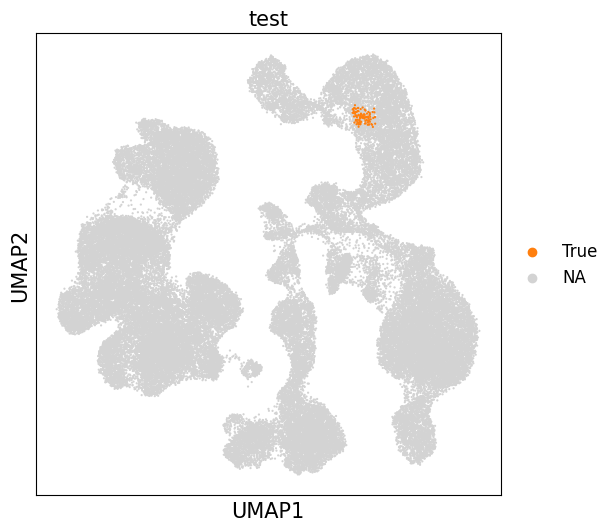

In [19]:
sc.pl.umap(adata, color='test', groups="True", size=10)

In [20]:
# cell 2

In [21]:
cell = adata[adata.obs.l2_cell_type == 'MK/E prog'].obs_names.to_series().sample(1, random_state=2).values 


In [22]:
cell_idx_2 = np.where(adata.obs_names.isin(cell))[0].item()

In [23]:
cell_neighbor_ids = neighbors_100[cell_idx_2].nonzero()[1]
neighbors_to_load_2 = [cell_idx_2] + cell_neighbor_ids.tolist() 

In [24]:
adata.obs['test'] = adata.obs_names.isin(adata.obs_names[neighbors_to_load_2]).astype(str)

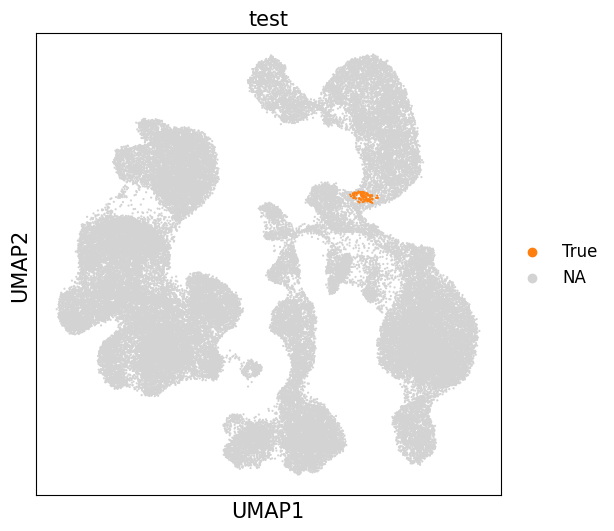

In [25]:
sc.pl.umap(adata, color='test', groups="True", size=10)

In [26]:
neighbors_to_load = neighbors_to_load_1 + neighbors_to_load_2

In [27]:
embedding_cell = torch.from_numpy(
            np.vstack(
                embedding.iloc[neighbors_to_load]['embedding'].values # gets embeddings of all cells of the cell type
                )
            ).cuda()

In [28]:
context_length = 524288
gene = "SLC25A37"
filter_val = lambda df: df.filter(pl.col('column_4').is_in([gene]))#
val_ds = GenomeIntervalDataset(
    bed_file = os.path.join(data_path, 'scooby_training_data', 'train_val_test_gene_sequences.csv'), 
    fasta_file = fasta_file,
    filter_df_fn = filter_val, 
    return_seq_indices = False,
    shift_augs = (0,0),
    rc_aug = False,
    return_augs = True,
    context_length = context_length,
    chr_bed_to_fasta_map = {}
)
len(val_ds)

1

In [29]:
val_dataset = onTheFlyMultiomeDataset(
    adatas=adatas,
    neighbors=neighbors,
    embedding=embedding,
    ds = val_ds, 
    clip_soft=5,
    cells_to_run=neighbors_to_load, 
    random_cells=False, 
    normalize_atac=True
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers = 0)
csb, val_loader = accelerator.prepare(csb, val_loader)

In [30]:
all_outputs_rna, all_outputs_atac, all_targets_rna, all_targets_atac = [], [], [], []

csb.eval()
# iterate over all val gene sequences
for i,x in tqdm.tqdm(enumerate(val_loader), disable = False, total=len(val_dataset)):   
    gene_slice, strand = get_gene_slice_and_strand(
        transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
    )
    bs = x[0].shape[0]
    seqs = x[0].cuda().permute(0,2,1)
    seqs_rev_comp =  torch.flip(seqs.permute(0,2,1), (-1, -2)).permute(0,2,1)
    stacked_outputs_rna, stacked_outputs_atac, stacked_counts_outputs_rna = [], [], []

    # go over embeddings for all cells of a cell type, sum the unsquashed predictions
    outputs = get_cell_profile_pred(csb, seqs, embedding_cell, predict, clip_soft=clip_soft, model_type='multiome', num_neighbors=1, chunk_size=70000)

    all_outputs_rna.append(outputs[0].detach().clone().cpu() if strand == '+' else outputs[1].detach().clone().cpu() ) 
    all_outputs_atac.append(outputs[2].detach().clone().cpu()) 
    
    targets = x[2].float().cuda()
    # get RNA:
    targets_rna = targets[:,:,torch.tensor([1,1,0]).repeat(targets.shape[2]//3).bool()]
    targets_rna = targets_rna.float().detach()

    num_pos = targets_rna.shape[-1]
    # get ATAC:
    targets_atac = targets[:,:,torch.tensor([0,0,1]).repeat(targets.shape[2]//3).bool()]
    targets_atac = targets_atac.float().detach()
    if strand == '+':
        all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, :num_pos:2], clip_soft=5).detach().clone().cpu().T)
    elif strand == '-':
        all_targets_rna.append(undo_squashed_scale(targets_rna[0, :, 1:num_pos:2], clip_soft=5).detach().clone().cpu().T)

    all_targets_atac.append(targets_atac[0].detach().clone().cpu().T)
    
all_outputs_rna, all_outputs_atac = torch.stack(all_outputs_rna, axis=0).clone().numpy(force=True), torch.stack(all_outputs_atac, axis=0).clone().numpy(force=True) 
all_targets_rna, all_targets_atac = torch.stack(all_targets_rna, axis=0).clone().numpy(force=True), torch.stack(all_targets_atac, axis=0).clone().numpy(force=True)

100%|██████████| 1/1 [00:05<00:00,  5.63s/it]


In [31]:
i=np.where(val_ds.df['column_4'] ==  gene)[0].item()

In [32]:
gtf = pr.read_gtf(gtf_file)

In [33]:
size=15
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': 5}
plt.rcParams.update(params)


print(val_dataset.genome_ds.df[i, 'column_4'])
gene = val_dataset.genome_ds.df[i, 'column_4']

# Get gene range
gene_slice, strand = get_gene_slice_and_strand(
        transcriptome, val_dataset.genome_ds.df[i, 'column_4'], val_dataset.genome_ds.df[i, 'column_2'], False
    )

# Get exons
exons = transcriptome.genes[
    gene
    ].output_slice(
        val_dataset.genome_ds.df[i, 'column_2'],
        6144*32,
        32,
        span=False,
        sliced=False
        ) 

# Get peaks
region = val_dataset.genome_ds.df[i].to_pandas()
region.columns = ['Chromosome', 'Start', 'End', 'Gene Name', 'Strand']
region = pr.PyRanges(region)
region_peaks = atac_peaks.overlap(region).df
region_peaks = region_to_bin(region_peaks.Start, region_peaks.End, val_dataset.genome_ds.df[i, 'column_2'], 6144*32, 32 )



loffset=1500
roffset=200
interval = (np.max([gene_slice.min()-loffset, 0]), gene_slice.max()+roffset)


# Get color map
color_map = dict(zip(adata.obs.l2_cell_type.cat.categories, adata.uns['l2_cell_type_colors']))
cell_type_1 = adata[cell_idx_1].obs.l2_cell_type.astype(str)
cell_type_2 = adata[cell_idx_2].obs.l2_cell_type.astype(str)


#ylim atac
ylim_atac = all_targets_atac[i, [0, 101], interval[0]: interval[1]].max() 
ylim_atac_100 = all_targets_atac[i, :, interval[0]: interval[1]].sum(axis=0).max()
ylim_atac_out = all_outputs_atac[i, [0,101], interval[0]: interval[1]].max()

#ylim rna
ylim_rna = all_targets_rna[i, [0, 101], interval[0]: interval[1]].max() 
ylim_rna_100 = all_targets_rna[i, :, interval[0]: interval[1]].sum(axis=0).max() 
ylim_rna_out = all_outputs_rna[i, [0, 101], interval[0]: interval[1]].max() 


## RNA cell 1
tracks_targets_rna_1 = list(
    zip(
         cell_type_1 + ': Observed (one cell)', 
        all_targets_rna[i, [0]], 
        np.repeat('coverage', 1),
        (0, ylim_rna)
    ))

tracks_targets_rna_100_1 = list(
    zip(
         cell_type_1 + ': Observed (sum across 100 neighbors)', 
        all_targets_rna[i, 0:101].sum(axis=0, keepdims=True) , 
        np.repeat('coverage', 1),
        (0, ylim_rna_100)
    ))

tracks_outputs_rna_1 = list(
    zip(
        cell_type_1 + ': Predictions', 
        all_outputs_rna[i, [0]]  ,
        np.repeat('coverage', 1),
        (0, ylim_rna_out),
    ))

## RNA cell 2

tracks_targets_rna_2 = list(
    zip(
         cell_type_2 + ': Observed (one cell)', 
        all_targets_rna[i, [101]], 
        np.repeat('coverage', 1),
        (0, ylim_rna)))

tracks_targets_rna_100_2 = list(
    zip(
         cell_type_2 + ': Observed (sum across 100 neighbors)', 
        all_targets_rna[i, 101:202].sum(axis=0, keepdims=True) , 
        np.repeat('coverage', 1),
        (0, ylim_rna_100)
    ))

tracks_outputs_rna_2 = list(
    zip(
        cell_type_2 + ': Predictions', 
        all_outputs_rna[i, [101]]  ,
        np.repeat('coverage', 1),
        (0, ylim_rna_out),
    ))

#ATAC cell 1

tracks_targets_atac_1 = list(zip(
    cell_type_1 + ': Observed (one cell)', 
    all_targets_atac[i, [0] ], 
    np.repeat('coverage', 1),
    (0, ylim_atac)))

tracks_targets_atac_100_1 = list(zip(
    cell_type_1 + ': Observed (sum across 100 neighbors)', 
    all_targets_atac[i, 0:101].sum(axis=0, keepdims=True) , 
    np.repeat('coverage', 1),
    (0, ylim_atac_100)
))


tracks_outputs_atac_1 = list(zip(
    cell_type_1 + ': Predictions', 
    all_outputs_atac[i, [0]], 
    np.repeat('coverage', 1),
    (0, ylim_atac_out )
))

#ATAC cell 2

tracks_targets_atac_2 = list(zip(
    cell_type_2 + ': Observed (one cell)', 
    all_targets_atac[i, [101]] , 
    np.repeat('coverage', 1),
    (0, ylim_atac)))

tracks_targets_atac_100_2 = list(zip(
    cell_type_2 + ': Observed (sum across 100 neighbors)', 
    all_targets_atac[i, 101:202].sum(axis=0, keepdims=True) , 
    np.repeat('coverage', 1),
    (0, ylim_atac_100)
))


tracks_outputs_atac_2 = list(zip(
    cell_type_2 + ': Predictions', 
    all_outputs_atac[i, [101]], 
    np.repeat('coverage', 1),
    (0, ylim_atac_out)
))

SLC25A37


In [34]:
plot = Plot()
plot.set_region( region.df["Chromosome"].item(), start= (region.df['Start'] + interval[0] * 32).item(), end= (region.df['Start'] + interval[1] * 32).item(), strand =strand)
plot.set_annotation(
    gtf_file,                                             # path to gtf file
    add_domain=False,                                                                # whether add domain information into annotation track
    show_gene=False,                                                                 # show gene id
    transcripts = sorted(gtf.df[gtf.df.gene_name.isin([gene]) & (gtf.df.Feature == 'transcript') & (gtf.df.transcript_support_level == "1")]['transcript_name'].values.tolist()), 
)

tracks_rna = [item for pair in zip(tracks_targets_rna_1, tracks_outputs_rna_1, tracks_targets_rna_100_1, tracks_targets_rna_2, tracks_outputs_rna_2, tracks_targets_rna_100_2) for item in pair] #
tracks_atac = [item for pair in zip(tracks_targets_atac_1, tracks_outputs_atac_1, tracks_targets_atac_100_1, tracks_targets_atac_2, tracks_outputs_atac_2, tracks_targets_atac_100_2) for item in pair]

2025-05-20 11:30:46.655 | INFO     | trackplot.plot:__init__:209 - Create trackplot version: 0.4.0
2025-05-20 11:30:46.658 | INFO     | trackplot.plot:set_region:265 - set region to chr8:23480945-23581841:+
2025-05-20 11:31:06.434 | INFO     | trackplot.plot:set_annotation:434 - set annotation file to /data/ceph/hdd/project/node_08/QNA/scborzoi/submission_data/gencode.v32.annotation.sorted.gtf.gz


0.35555553436279297 4.033335
0.0 0.71111107


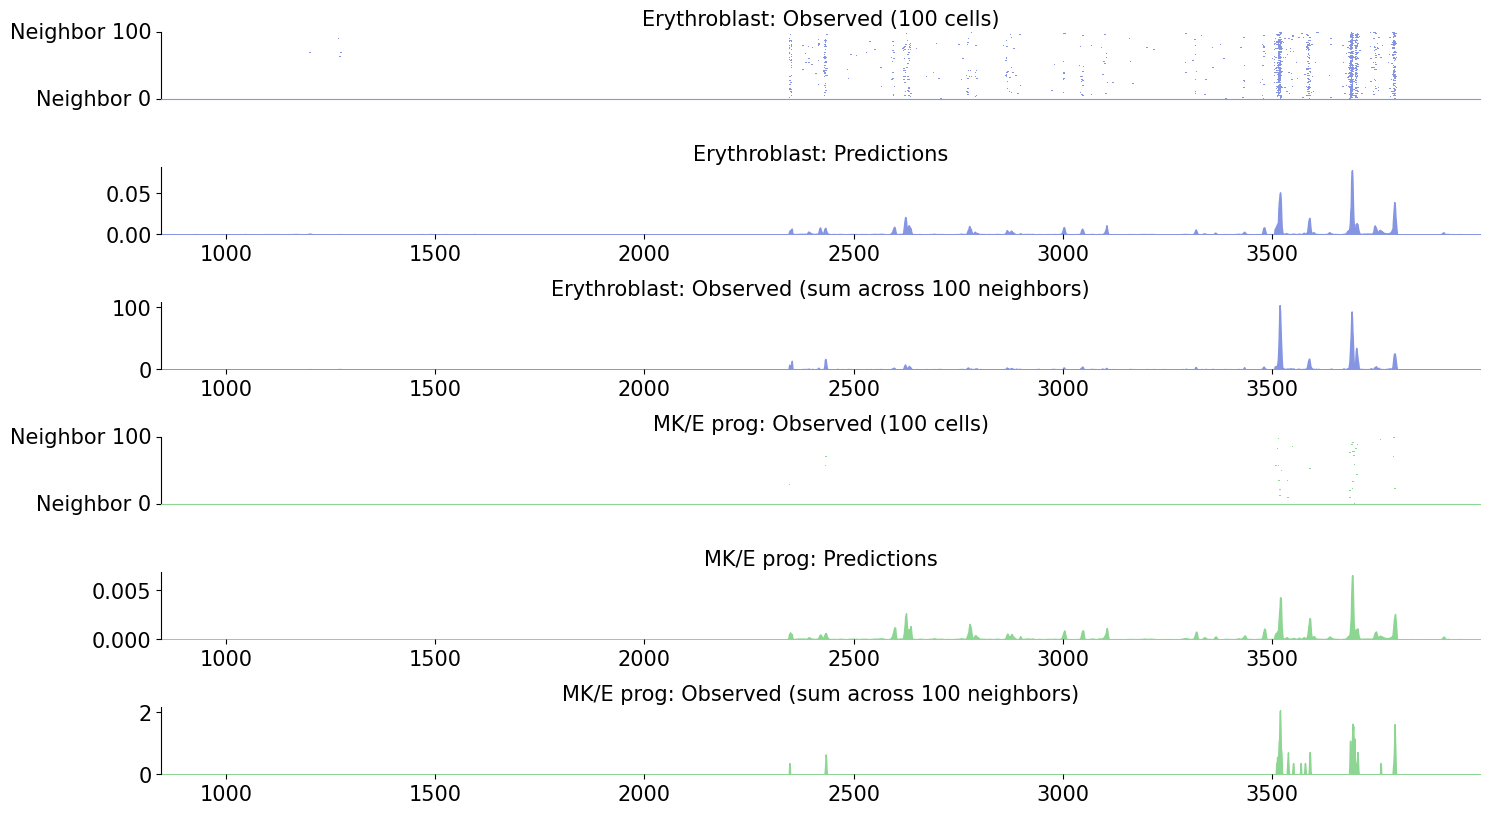

In [35]:
tracks =  tracks_rna  
out1 = plot_tracks(
    tracks=tracks, 
    interval=interval, 
    color_map=color_map, 
    fig_title=None,
    height=1.4,
#    annotation_plot = plot,
    annotation_scale=2,
    save_name=None,
)

add_heatmap_to_axes(
    out1, 
    0, 
    all_targets_rna[i, :101, interval[0]: interval[1]],
    color_map[cell_type_1.item()],
    "Erythroblast: Observed (100 cells)",
    vmax=0.01111126
)
add_heatmap_to_axes(
    out1, 
    3, 
    all_targets_rna[i, 101:202, interval[0]: interval[1]],
    color_map[cell_type_2.item()],
    "MK/E prog: Observed (100 cells)",
    vmax=0.01111126
)
[ax.set_rasterization_zorder(1) for ax in out1[1]]
out1[0].tight_layout()
out1[0].savefig(f'../figures/Figure1/{gene}_RNA.svg', bbox_inches='tight', dpi=300)

2025-05-20 11:32:03.671 | INFO     | trackplot.plot:plot:1093 - load annotation
2025-05-20 11:32:03.685 | INFO     | trackplot.plot:plot:1107 - load data of 0 plots
2025-05-20 11:32:03.686 | DEBUG    | trackplot.plot:plot:1159 - plots n_rows=41; n_cols = 1
2025-05-20 11:32:03.687 | INFO     | trackplot.plot:plot:1160 - init graph_coords
2025-05-20 11:32:03.837 | INFO     | trackplot.plot:plot:1328 - plotting x-axis ticks at idx: 0 with height_ratio: 1
2025-05-20 11:32:03.837 | INFO     | trackplot.plot:plot:1338 - plotting annotation at idx: 0 with height_ratio: 1


1.0
0.35555553436279297 4.033335
0.0 0.71111107


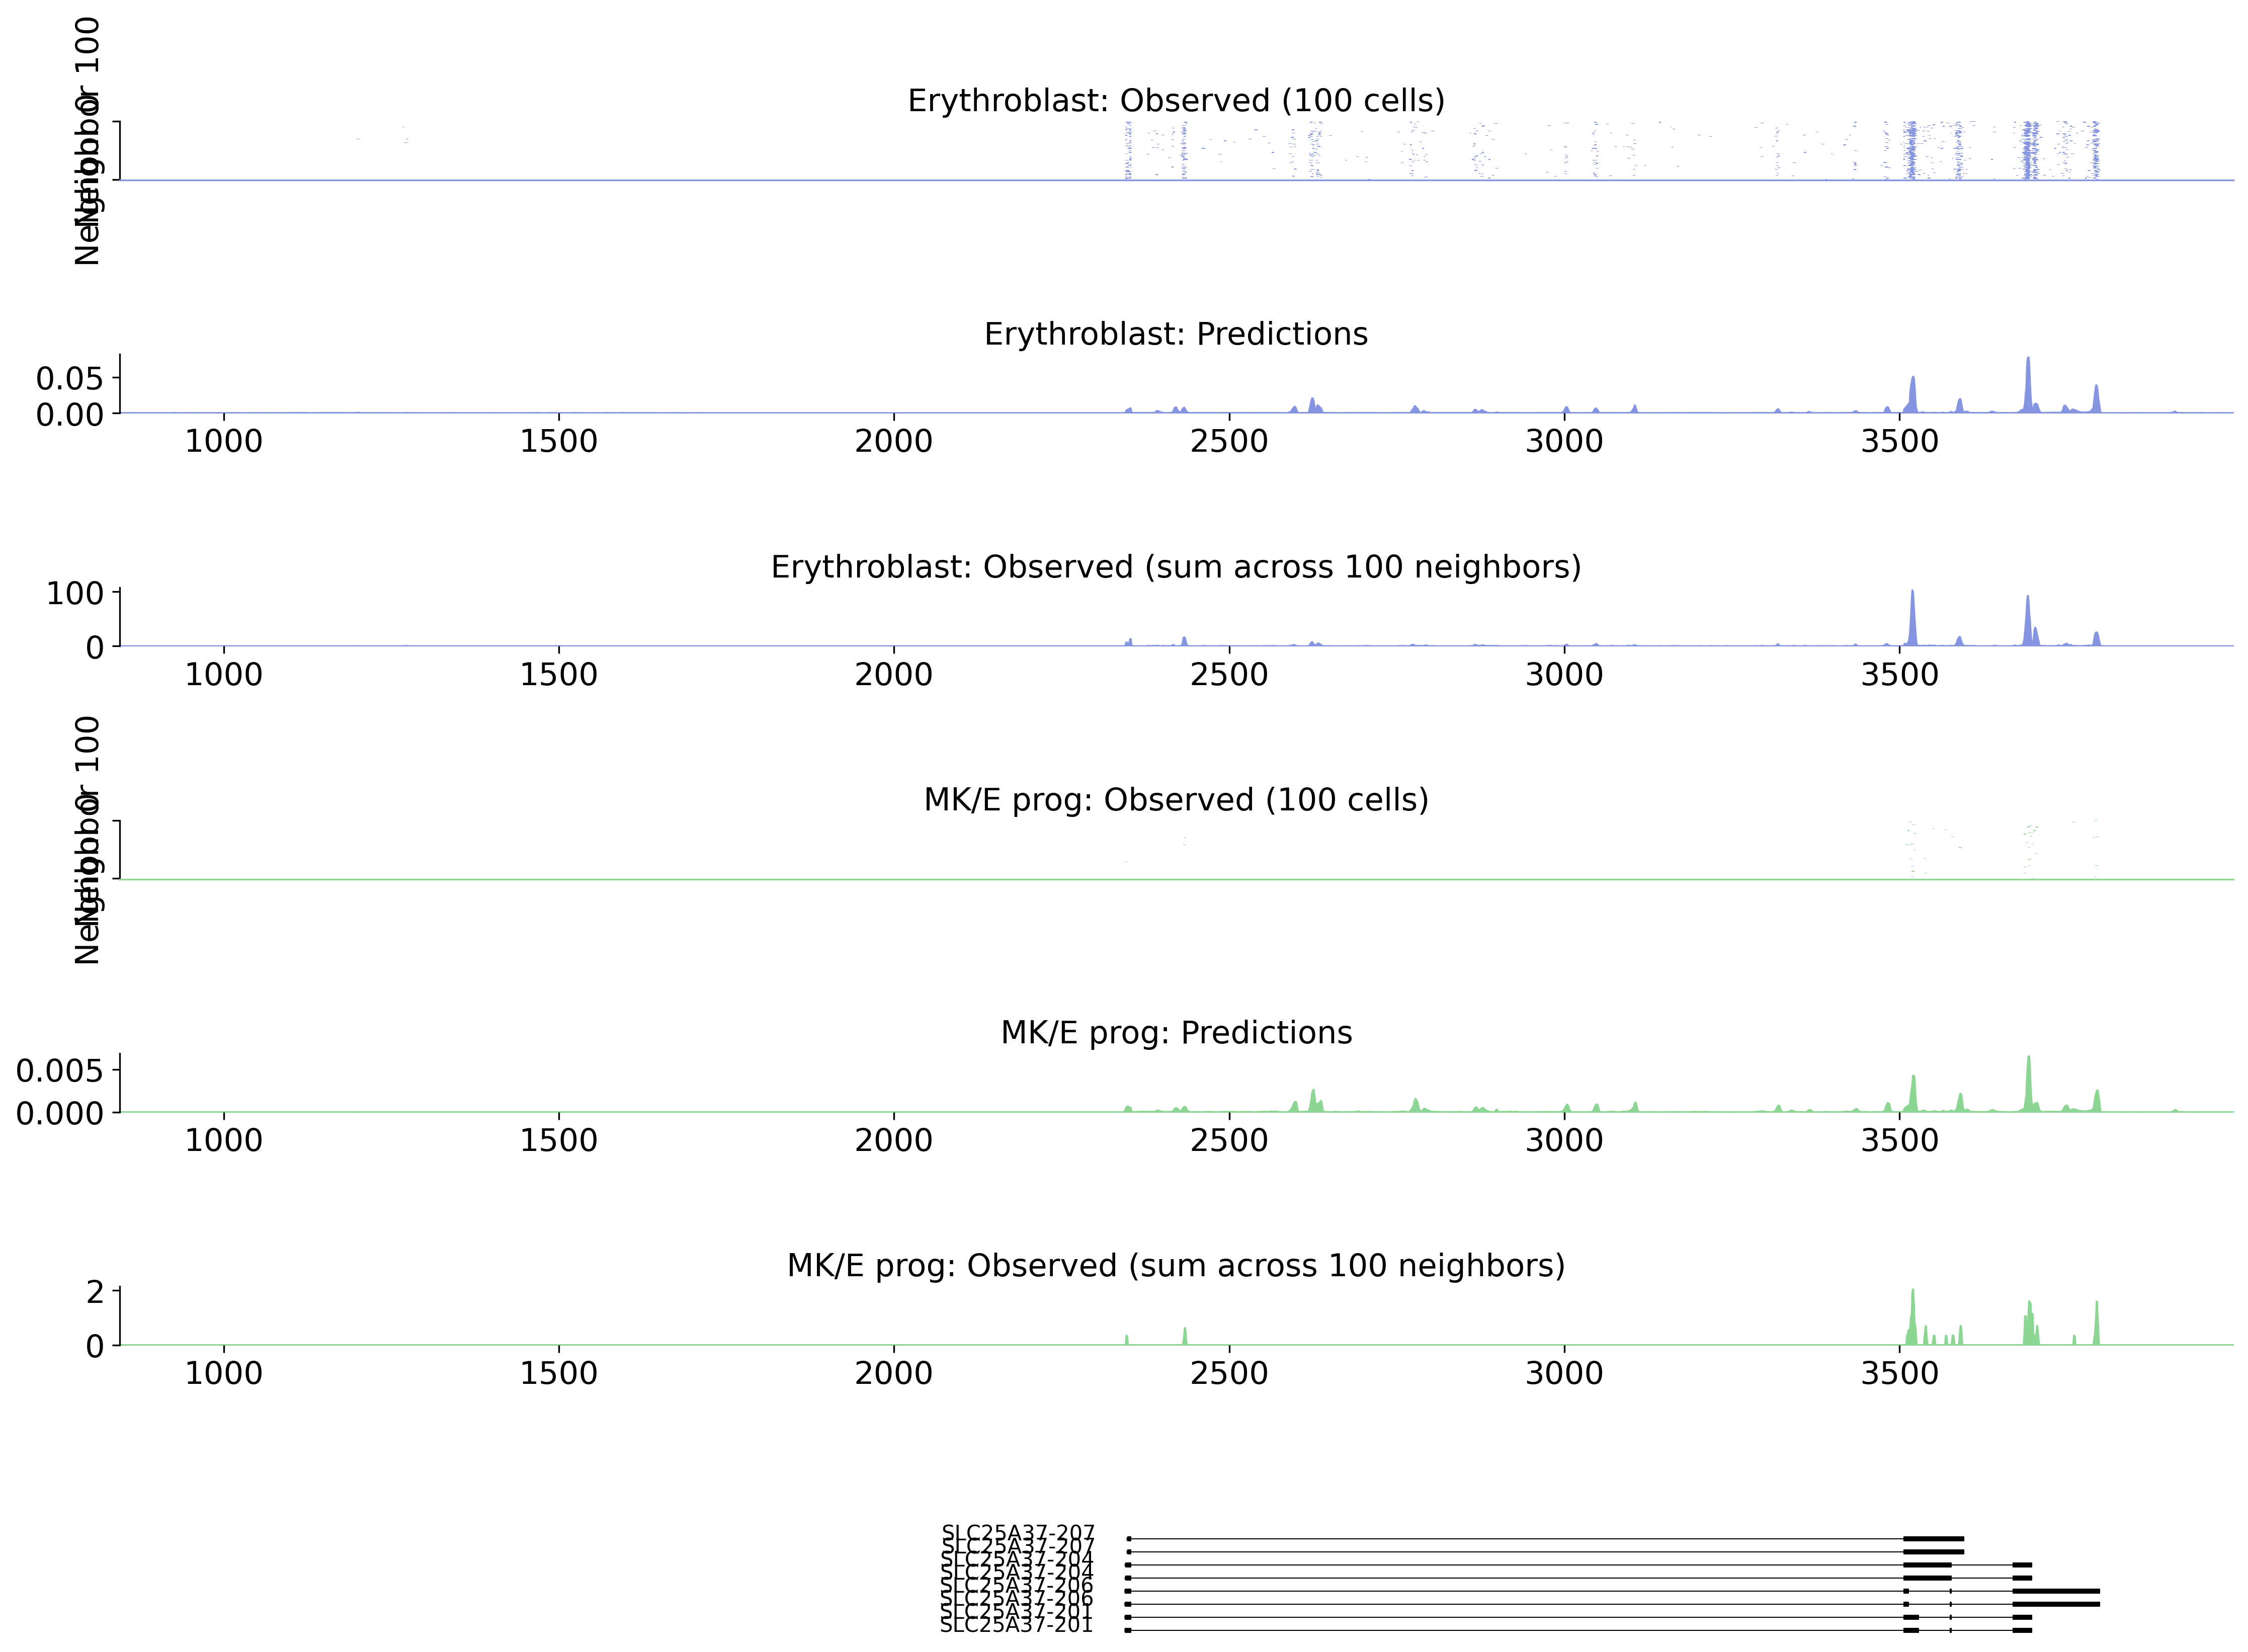

In [38]:
tracks =  tracks_rna  
out1 = plot_tracks(
    tracks=tracks, 
    interval=interval, 
    color_map=color_map, 
    fig_title=None,
    height=1.4,
    annotation_plot = plot,
    annotation_scale=2,
    save_name=None,
)

add_heatmap_to_axes(
    out1, 
    0, 
    all_targets_rna[i, :101, interval[0]: interval[1]],
    color_map[cell_type_1.item()],
    "Erythroblast: Observed (100 cells)",
    vmax=0.01111126
)
add_heatmap_to_axes(
    out1, 
    3, 
    all_targets_rna[i, 101:202, interval[0]: interval[1]],
    color_map[cell_type_2.item()],
    "MK/E prog: Observed (100 cells)",
    vmax=0.01111126
)
out1[0].set_dpi(300)
out1[0].tight_layout()
out1[0].savefig(f'../figures/Figure1/{gene}_RNA_annotation.svg', bbox_inches='tight', dpi=300)

0.35555553436279297 4.033335
0.0 0.71111107


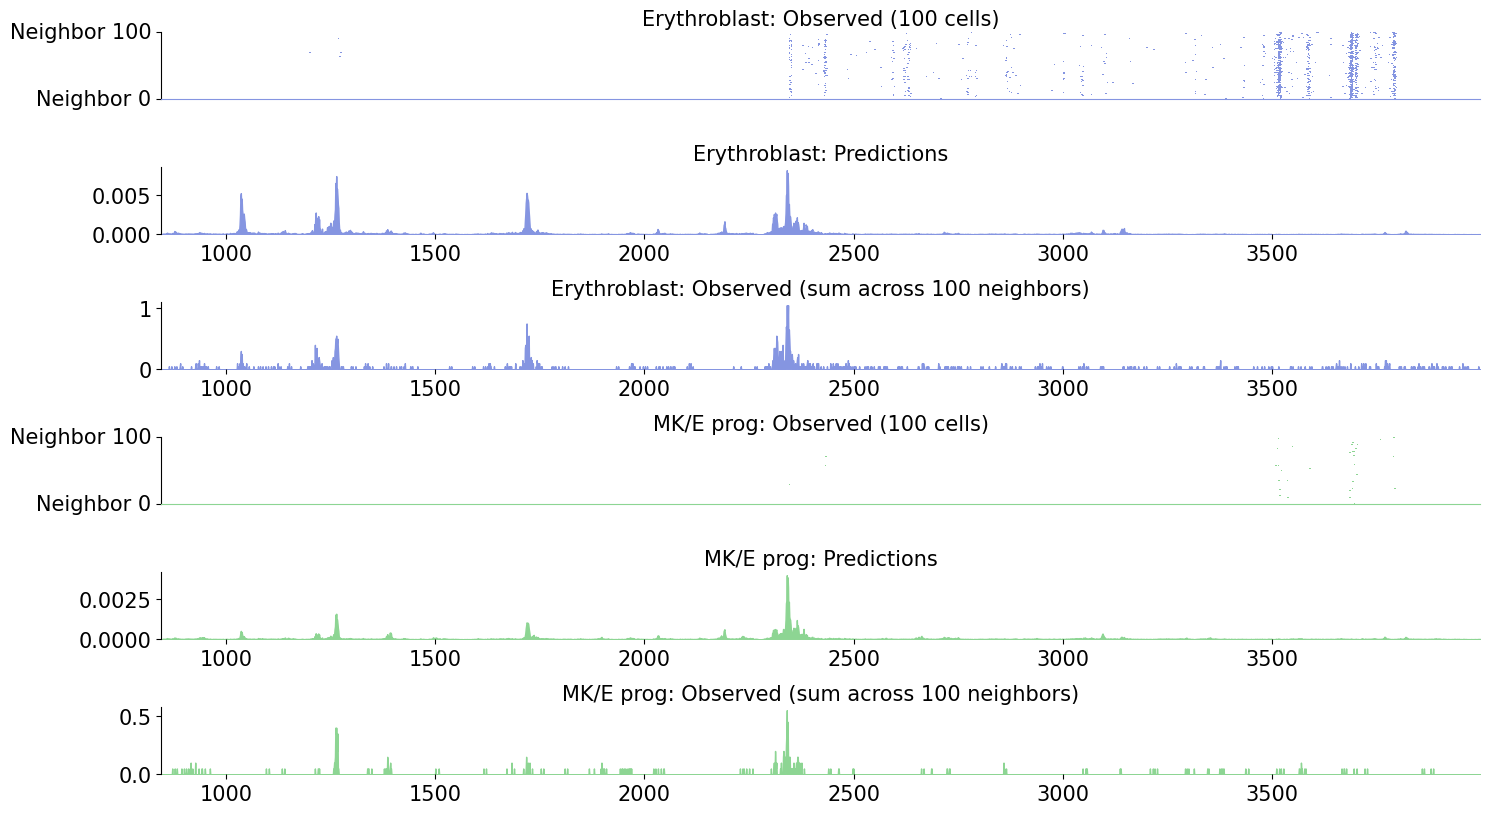

In [39]:
tracks =  tracks_atac  
out1 = plot_tracks(
    tracks=tracks, 
    interval=interval, 
    color_map=color_map, 
    fig_title=None,
    height=1.4,
#    annotation_plot = plot,
    annotation_scale=2,
    save_name=None,
)

add_heatmap_to_axes(
    out1, 
    0, 
    all_targets_rna[i, :101, interval[0]: interval[1]],
    color_map[cell_type_1.item()],
    "Erythroblast: Observed (100 cells)",
    vmax=0.01111126
)
add_heatmap_to_axes(
    out1, 
    3, 
    all_targets_rna[i, 101:202, interval[0]: interval[1]],
    color_map[cell_type_2.item()],
    "MK/E prog: Observed (100 cells)",
    vmax=0.01111126
)
#out1[0].set_dpi(300)
out1[0].tight_layout()
out1[0].savefig(f'../figures/Figure1/{gene}_ATAC.svg', bbox_inches='tight', dpi=300)